###SWI2 Example 1. Rotating Interface

This example problem is the first example problem in the SWI2 documentation (http://pubs.usgs.gov/tm/6a46/) and simulates transient movement of a freshwater\seawater interface separating two density zones in a two-dimensional vertical plane. The problem domain is 250 m long, 40 m high, and 1 m wide. The aquifer is confined, storage changes are not considered (all MODFLOW stress periods are steady-state), and the top and bottom of the aquifer are horizontal and impermeable.

The domain is discretized into 50 columns, 1 row, and 1 layer, with respective cell dimensions of 5 m (`DELR`), 1 m (`DELC`), and 40 m. A constant head of 0 m is specified for column 50. The hydraulic conductivity is 2 m/d and the effective porosity (`SSZ`) is 0.2. A flow of 1 m$^3$/d of seawater is specified in column 1 and causes groundwater to flow from left to right
in the model domain.

The domain contains one freshwater zone and one seawater zone, separated by an active `ZETA` surface between the zones (`NSRF=1`) that approximates the 50-percent seawater salinity contour. A 400-day period is simulated using a constant time step of 2 days. Fluid density is represented using the stratified option (`ISTRAT=1`) and the elevation of the interface is output every 100 days (every 50 time steps). The densities, $\rho$, of the freshwater and saltwater are 1,000 and 1,025 kg/m$^3$, respectively. Hence, the dimensionless densities, $\nu$, of the freshwater and saltwater are 0.0 and 0.025, respectively. The maximum slope of the toe and tip is specified as 0.2 (`TOESLOPE=TIPSLOPE=0.2`), and default tip/toe parameters are used (`ALPHA=BETA=0.1`). Initially, the interface is at a 45$^{\circ}$ angle from (x,z) = (80,0) to (x,z) = (120,-40). The source/sink terms (`ISOURCE`) are specified to be freshwater everywhere (`ISOURCE=1`) except in cell 1 where saltwater enters the model and `ISOURCE` equals 2. A comparison of results for SWI2 and the exact Dupuit solution of Wilson and Sa Da Costa (1982) are presented below. The constant flow from left to right results in an average velocity of 0.125 m/d. The exact Dupuit solution is a rotating straight interface of which the center moves to the right with this velocity

Import `numpy` and `matplotlib`, set all figures to be inline, import `flopy.modflow` and `flopy.utils`.

In [1]:
%matplotlib inline
import os
import platform
import numpy as np
import matplotlib.pyplot as plt

import flopy.modflow as mf
import flopy.utils as fu
import flopy.plot as fp

Define model name of your model and the location of MODFLOW executable. All MODFLOW files and output will be stored in the subdirectory defined by the workspace. Create a model named `ml` and specify that this is a MODFLOW-2005 model.

In [2]:
modelname = 'swiex1'

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mf2005'
if platform.system() == 'Windows':
    exe_name = 'mf2005.exe'

workspace = os.path.join('data')
#make sure workspace directory exists
if not os.path.exists(workspace):
    os.makedirs(workspace)

ml = mf.Modflow(modelname, version='mf2005', exe_name=exe_name, model_ws=workspace)

Define the number of layers, rows and columns, and the cell size along the rows (`delr`) and along the columns (`delc`). Then create a discretization file. Specify the top and bottom of the aquifer. The heads are computed quasi-steady state (hence a steady MODFLOW run) while the interface will move. There is one stress period with a length of 400 days and 200 steps (so one step is 2 days). 

In [3]:
nlay = 1
nrow = 1
ncol = 50
delr = 5.
delc = 1.
nper, perlen, nstp = 1, 400., 200 
discret = mf.ModflowDis(ml, nlay=nlay, nrow=nrow, ncol=ncol,
                        delr=delr, delc=delc,
                        top=0, botm=-40.0,
                        steady=True, nper=nper, perlen=perlen, nstp=nstp)

All cells are active (`ibound=1`), while the last cell is fixed head (`ibound=-1`). The starting values of the head are not important, as the heads are computed every time with a steady run.

In [4]:
ibound = np.ones((nrow, ncol))
ibound[0, -1] = -1
bas = mf.ModflowBas(ml, ibound=ibound, strt=0.0)

Define the hydraulic conductivity. The aquifer is confined (`laytype=0`) and the intercell hydraulic conductivity is the harmonic meand (`layavg=0`).

In [5]:
lpf = mf.ModflowLpf(ml, hk=2., laytyp=0, layavg=0)

Inflow on the right side of the model is 1 m$^3$/d (layer 0, row 0, column 0, discharge 1)

In [6]:
wel = mf.ModflowWel(ml, stress_period_data = {0:[[0, 0, 0, 1]]} )

Define the output control to save heads and interface every 50 steps, and define the pcg solver with default arguments.

In [7]:
spd = {}
for istp in range(49, nstp+1, 50):
    spd[(0, istp)] = ['save head', 'print budget']
    spd[(0, istp+1)] = []

oc = mf.ModflowOc(ml, stress_period_data=spd)
pcg = mf.ModflowPcg(ml)

The intial interface is straight. The isource is one everywhere (inflow and outflow is fresh (zone 1)) except for the first cell (index=0) which has saltwater inflow (zone 2).

In [8]:
z = np.zeros((nrow, ncol), np.float)
z[0, 16:24] = np.arange(-2.5, -40, -5)
z[0, 24:] = -40
z = [z]  # zeta needs to be 
isource = np.ones((nrow, ncol), np.int)
isource[0, 0] = 2
#
swi = mf.ModflowSwi2(ml, nsrf=1, istrat=1, toeslope=0.2, tipslope=0.2, nu=[0, 0.025],
                     zeta=z, ssz=0.2, isource=isource, nsolver=1)

Write the MODFLOW input files and run the model

In [9]:
ml.write_input()
ml.run_model(silent=True)

[True, []]

Load the head and zeta data from the file

In [10]:
# read model heads
hfile = fu.HeadFile(os.path.join(ml.model_ws, modelname+'.hds'))
head = hfile.get_alldata()
# read model zeta
zfile = fu.CellBudgetFile(os.path.join(ml.model_ws, modelname+'.zta'))
kstpkper = zfile.get_kstpkper()
zeta = []
for kk in kstpkper:
    zeta.append(zfile.get_data(kstpkper=kk, text='ZETASRF  1')[0])
zeta = np.array(zeta)

Make a graph and add the solution of Wilson and Sa da Costa

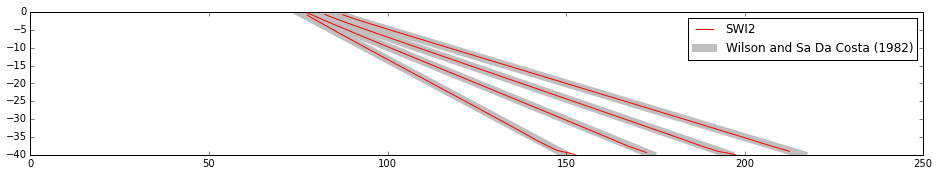

In [11]:
plt.figure(figsize=(16,6))
# define x-values of xcells and plot interface
x = np.arange(0, ncol*delr, delr) + delr/2.
label = ['SWI2','_','_','_'] # labels with an underscore are not added to legend
for i in range(4):
    zt = np.ma.masked_outside(zeta[i,0,0,:], -39.99999, -0.00001)
    plt.plot(x, zt, 'r-', lw=1, 
             zorder=10, label=label[i])
# Data for the Wilson - Sa da Costa solution
k = 2.0
n = 0.2
nu = 0.025
H = 40.0
tzero = H * n / (k * nu) / 4.0
Ltoe = np.zeros(4)
v = 0.125
t = np.arange(100, 500, 100)
label = ['Wilson and Sa Da Costa (1982)','_','_','_'] # labels with an underscore are not added to legend
for i in range(4):
    Ltoe[i] = H * np.sqrt(k * nu * (t[i] + tzero) / n / H)
    plt.plot([100 - Ltoe[i] + v * t[i], 100 + Ltoe[i] + v * t[i]], [0, -40], '0.75', 
             lw=8, zorder=0, label=label[i])
# Scale figure and add legend
plt.axis('scaled')
plt.xlim(0, 250)
plt.ylim(-40, 0)
plt.legend(loc='best');

Use ModelCrossSection plotting class and plot_surface() method to plot zeta surfaces.

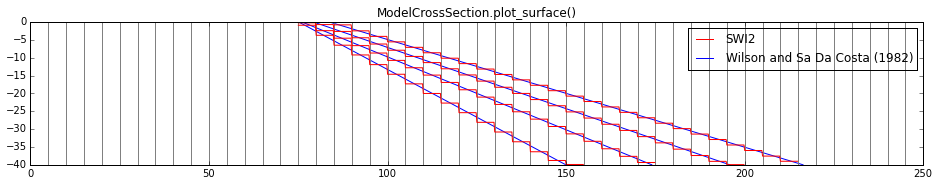

In [12]:
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = fp.ModelCrossSection(model=ml, line={'Row': 0})
label = ['SWI2','_','_','_']
for k in range(zeta.shape[0]):
    modelxsect.plot_surface(zeta[k, :, :, :], masked_values=[0, -40.], 
                              color='red', lw=1, label=label[k])
linecollection = modelxsect.plot_grid()
ax.set_title('ModelCrossSection.plot_surface()')
# Data for the Wilson - Sa da Costa solution
k = 2.0
n = 0.2
nu = 0.025
H = 40.0
tzero = H * n / (k * nu) / 4.0
Ltoe = np.zeros(4)
v = 0.125
t = np.arange(100, 500, 100)
label = ['Wilson and Sa Da Costa (1982)','_','_','_'] # labels with an underscore are not added to legend
for i in range(4):
    Ltoe[i] = H * np.sqrt(k * nu * (t[i] + tzero) / n / H)
    ax.plot([100 - Ltoe[i] + v * t[i], 100 + Ltoe[i] + v * t[i]], [0, -40], 'blue',
            lw=1, zorder=0, label=label[i])
# Scale figure and add legend
ax.axis('scaled')
ax.set_xlim(0, 250)
ax.set_ylim(-40, 0)
ax.legend(loc='best');

Use ModelCrossSection plotting class and plot_fill_between() method to fill between zeta surfaces.

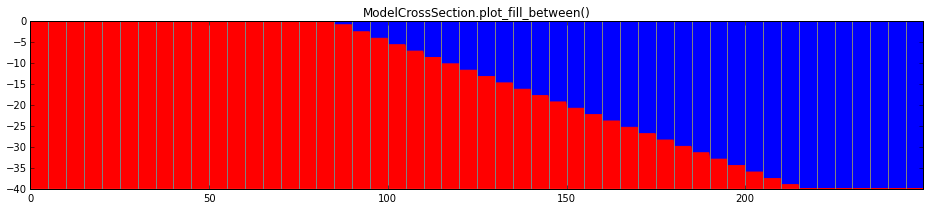

In [13]:
fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = fp.ModelCrossSection(model=ml, line={'Row': 0})
modelxsect.plot_fill_between(zeta[3, :, :, :])
linecollection = modelxsect.plot_grid()
ax.set_title('ModelCrossSection.plot_fill_between()');

Convert zeta surfaces to relative seawater concentrations

[ 1.00000001  1.00000001  1.00000001  1.00000001  1.00000001  1.00000001
  1.00000001  1.00000001  1.00000001  1.00000001  1.00000001  1.00000001
  1.00000001  1.00000001  1.00000001  1.00000001  1.00000001  0.97957368
  0.93777831  0.89900599  0.8606122   0.82240776  0.78431243  0.74628681
  0.70830902  0.6703652   0.63244558  0.59454289  0.55665098  0.5187645
  0.4808785   0.44298783  0.40508729  0.36717053  0.32923027  0.29125705
  0.25323816  0.21515508  0.17697897  0.13865538  0.10004826  0.06099987
  0.02483263  0.          0.          0.          0.          0.          0.
  0.        ]


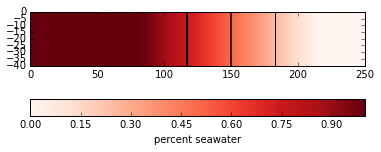

In [14]:
X, Y = np.meshgrid(x, [0, -40])
zc = fp.SwiConcentration(model=ml)
conc = zc.calc_conc(zeta={0:zeta[3,:,:,:]}) / 0.025
print(conc[0, 0, :])
v = np.vstack((conc[0, 0, :], conc[0, 0, :]))
plt.imshow(v, extent=[0, 250, -40, 0], cmap='Reds')
cb = plt.colorbar(orientation='horizontal')
cb.set_label('percent seawater');
plt.contour(X, Y, v, [0.75, 0.5, 0.25], linewidths=[2, 1.5, 1], colors='black');